In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision.datasets import CIFAR10
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
from sklearn.metrics import accuracy_score
from google.colab import drive 

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class RotationDataset(Dataset):
    def __init__(self,train=True):
        self.ds = CIFAR10(".",download=True,train=train)
        self.Tens = transforms.ToTensor()
    def __len__(self):
        return(len(self.ds))
    def __getitem__(self,idx):
        X = self.ds[idx][0]
        rot = np.random.choice(4)
        X = X.rotate(rot*90)
        
        
        return self.Tens(X),torch.tensor(rot)
                                                       
    

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
train_set=RotationDataset()
val_set = RotationDataset(train=False)
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)
val_loader = DataLoader(val_set,batch_size=64,shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [9]:
model = resnet34(pretrained=False)
model.fc=nn.Linear(512,4)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    model_save_name = filename
    path = F"/content/drive/My Drive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model,optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    iter_train_loss = checkpoint["iter_train_loss"]
    iter_val_loss = checkpoint["iter_val_loss"]

In [11]:
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 50
load_model = False
if load_model :
  model_save_name ="my_checkpoint.pth.tar"
  path = F"/content/drive/My Drive/{model_save_name}" 
  load_checkpoint(torch.load(path),model,optimizer)

In [13]:
train_loss = []
val_loss = []
for epoch in range(epochs):
  model.train()
  if epoch % 5 == 1:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict(),
                  'iter_train_loss' : iter_train_loss ,'iter_val_loss' : iter_val_loss 
                  }
    save_checkpoint(checkpoint, filename="my_checkpoint.pth.tar")

  iter_train_loss = 0
  iter_val_loss=0
  
  for X,y in train_loader:

    optimizer.zero_grad()        
    X = X.to(device)
    y = y.to(device)
    out = model(X)
    loss = loss_fn(out,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    iter_train_loss += loss


  train_loss.append(iter_train_loss/len(train_set))
  print("Epoch: {0} \t Loss: {1:.4f} ".format(epoch, iter_train_loss/len(train_set)))
  with torch.no_grad():
    model.eval()
    iter_loss=0
    for X,y in val_loader:
      
      X = X.to(device)
      y = y.to(device)
      out = model(X)
      loss = loss_fn(out,y)
      loss = loss.item()
      iter_val_loss +=loss
    val_loss.append(iter_val_loss/len(val_set))


Epoch: 0 	 Loss: 0.0232 
=> Saving checkpoint
Epoch: 1 	 Loss: 0.0220 
Epoch: 2 	 Loss: 0.0213 
Epoch: 3 	 Loss: 0.0207 
Epoch: 4 	 Loss: 0.0203 
Epoch: 5 	 Loss: 0.0200 
=> Saving checkpoint
Epoch: 6 	 Loss: 0.0196 
Epoch: 7 	 Loss: 0.0194 
Epoch: 8 	 Loss: 0.0192 
Epoch: 9 	 Loss: 0.0189 
Epoch: 10 	 Loss: 0.0187 
=> Saving checkpoint
Epoch: 11 	 Loss: 0.0185 
Epoch: 12 	 Loss: 0.0183 
Epoch: 13 	 Loss: 0.0182 
Epoch: 14 	 Loss: 0.0181 
Epoch: 15 	 Loss: 0.0179 
=> Saving checkpoint
Epoch: 16 	 Loss: 0.0179 
Epoch: 17 	 Loss: 0.0177 
Epoch: 18 	 Loss: 0.0176 
Epoch: 19 	 Loss: 0.0175 
Epoch: 20 	 Loss: 0.0174 
=> Saving checkpoint
Epoch: 21 	 Loss: 0.0173 
Epoch: 22 	 Loss: 0.0172 
Epoch: 23 	 Loss: 0.0172 
Epoch: 24 	 Loss: 0.0171 
Epoch: 25 	 Loss: 0.0170 
=> Saving checkpoint
Epoch: 26 	 Loss: 0.0169 
Epoch: 27 	 Loss: 0.0169 
Epoch: 28 	 Loss: 0.0168 
Epoch: 29 	 Loss: 0.0168 
Epoch: 30 	 Loss: 0.0168 
=> Saving checkpoint
Epoch: 31 	 Loss: 0.0166 
Epoch: 32 	 Loss: 0.0166 
Epoch

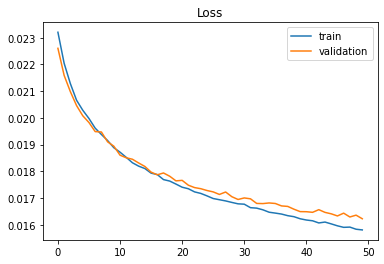

In [14]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='validation')
plt.legend()
plt.title("Loss")
plt.show()

# stage 4

In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
stage4=nn.Sequential(model.conv1,model.bn1,model.relu,model.maxpool,model.layer1,model.layer2
                     ,model.layer3,model.layer4,nn.Flatten(),nn.Linear(512,10)).to(device)

In [17]:
clf_train_set=CIFAR10(".",transform=transforms.ToTensor())
clf_val_set=CIFAR10(".",train=False,transform=transforms.ToTensor())
clf_train_loader = DataLoader(clf_train_set,batch_size=64,shuffle=True)
clf_val_loader = DataLoader(clf_val_set,batch_size=64,shuffle=True)

In [18]:
optimizer = torch.optim.SGD(stage4.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 50

In [30]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  model.train()
  iter_loss = 0
  count_corr = 0
  total_corr = 0
  for X,y in clf_train_loader:

    optimizer.zero_grad()        
    X = X.to(device)
    y = y.to(device)
    out = stage4(X)
    loss = loss_fn(out,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    iter_loss += loss
    pre = torch.argmax(out,dim=1)
    count_corr = (pre == y).sum().item()
    total_corr += count_corr
    

  train_acc.append(total_corr*100/len(clf_train_set))
  train_loss.append(iter_loss/len(clf_train_set))
  print("Epoch: {0} \t Loss: {1:.4f} \t Accuracy: {2:.1f} ".format(epoch,train_loss[-1] ,train_acc[-1]))


  with torch.no_grad():
    model.eval()
    iter_loss=0
    count_corr = 0
    for X,y in clf_val_loader:
      X = X.to(device)
      y = y.to(device)
      out = stage4(X)
      loss = loss_fn(out,y)
      loss = loss.item()
      iter_loss +=loss
      pre = torch.argmax(out,dim=1)
      count_corr += (pre == y).sum().item()

      
    val_loss.append(iter_loss/len(clf_val_set))
    val_acc.append(count_corr*100/len(clf_val_set))
    


Epoch: 0 	 Loss: 0.0310 	 Accuracy: 27.7 
Epoch: 1 	 Loss: 0.0309 	 Accuracy: 27.7 
Epoch: 2 	 Loss: 0.0308 	 Accuracy: 28.0 
Epoch: 3 	 Loss: 0.0308 	 Accuracy: 28.2 
Epoch: 4 	 Loss: 0.0308 	 Accuracy: 28.0 
Epoch: 5 	 Loss: 0.0307 	 Accuracy: 28.1 
Epoch: 6 	 Loss: 0.0306 	 Accuracy: 28.5 
Epoch: 7 	 Loss: 0.0306 	 Accuracy: 28.6 
Epoch: 8 	 Loss: 0.0306 	 Accuracy: 28.6 
Epoch: 9 	 Loss: 0.0306 	 Accuracy: 28.6 
Epoch: 10 	 Loss: 0.0305 	 Accuracy: 29.0 
Epoch: 11 	 Loss: 0.0305 	 Accuracy: 28.8 
Epoch: 12 	 Loss: 0.0305 	 Accuracy: 28.9 
Epoch: 13 	 Loss: 0.0304 	 Accuracy: 29.2 
Epoch: 14 	 Loss: 0.0304 	 Accuracy: 29.4 
Epoch: 15 	 Loss: 0.0304 	 Accuracy: 29.3 
Epoch: 16 	 Loss: 0.0303 	 Accuracy: 29.4 
Epoch: 17 	 Loss: 0.0303 	 Accuracy: 29.5 
Epoch: 18 	 Loss: 0.0303 	 Accuracy: 29.5 
Epoch: 19 	 Loss: 0.0302 	 Accuracy: 29.6 
Epoch: 20 	 Loss: 0.0302 	 Accuracy: 29.7 
Epoch: 21 	 Loss: 0.0302 	 Accuracy: 29.8 
Epoch: 22 	 Loss: 0.0302 	 Accuracy: 29.7 
Epoch: 23 	 Loss: 0.0

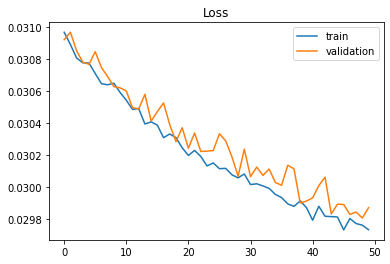

In [31]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='validation')
plt.legend()
plt.title("Loss")
plt.show()

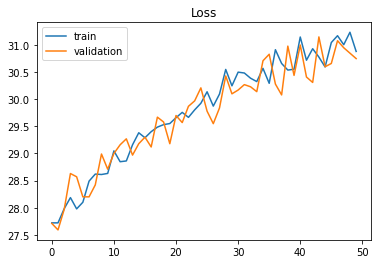

In [32]:
plt.plot(train_acc,label='train')
plt.plot(val_acc,label='validation')
plt.legend()
plt.title("Loss")
plt.show()

# stage 2

In [35]:
for param in model.parameters():
    param.requires_grad = False

stage2=nn.Sequential(model.conv1,model.bn1,model.relu,model.maxpool,model.layer1,model.layer2
                     ,nn.MaxPool2d(kernel_size=2),nn.Flatten(),nn.Linear(512,10)).to(device)

optimizer = torch.optim.SGD(stage2.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 50


In [36]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for epoch in range(epochs):
  stage2.train()
  iter_loss = 0
  count_corr = 0
  total_corr = 0
  for X,y in clf_train_loader:

    optimizer.zero_grad()        
    X = X.to(device)
    y = y.to(device)
    out = stage2(X)
    loss = loss_fn(out,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    iter_loss += loss
    pre = torch.argmax(out,dim=1)
    count_corr = (pre == y).sum().item()
    total_corr += count_corr
    

  train_acc.append(total_corr*100/len(clf_train_set))
  train_loss.append(iter_loss/len(clf_train_set))
  print("Epoch: {0} \t Loss: {1:.4f} \t Accuracy: {2:.1f} ".format(epoch,train_loss[-1] ,train_acc[-1]))


  with torch.no_grad():
    model.eval()
    iter_loss=0
    count_corr = 0
    for X,y in clf_val_loader:
      X = X.to(device)
      y = y.to(device)
      out = stage2(X)
      loss = loss_fn(out,y)
      loss = loss.item()
      iter_loss +=loss
      pre = torch.argmax(out,dim=1)
      count_corr += (pre == y).sum().item()

      
    val_loss.append(iter_loss/len(clf_val_set))
    val_acc.append(count_corr*100/len(clf_val_set))
    


Epoch: 0 	 Loss: 0.0377 	 Accuracy: 12.4 
Epoch: 1 	 Loss: 0.0345 	 Accuracy: 18.0 
Epoch: 2 	 Loss: 0.0331 	 Accuracy: 21.5 
Epoch: 3 	 Loss: 0.0323 	 Accuracy: 23.8 
Epoch: 4 	 Loss: 0.0317 	 Accuracy: 25.7 
Epoch: 5 	 Loss: 0.0312 	 Accuracy: 27.3 
Epoch: 6 	 Loss: 0.0308 	 Accuracy: 27.8 
Epoch: 7 	 Loss: 0.0304 	 Accuracy: 29.0 
Epoch: 8 	 Loss: 0.0302 	 Accuracy: 29.7 
Epoch: 9 	 Loss: 0.0299 	 Accuracy: 30.2 
Epoch: 10 	 Loss: 0.0297 	 Accuracy: 31.0 
Epoch: 11 	 Loss: 0.0295 	 Accuracy: 31.5 
Epoch: 12 	 Loss: 0.0292 	 Accuracy: 31.8 
Epoch: 13 	 Loss: 0.0290 	 Accuracy: 32.6 
Epoch: 14 	 Loss: 0.0289 	 Accuracy: 32.9 
Epoch: 15 	 Loss: 0.0287 	 Accuracy: 33.4 
Epoch: 16 	 Loss: 0.0286 	 Accuracy: 33.7 
Epoch: 17 	 Loss: 0.0285 	 Accuracy: 34.0 
Epoch: 18 	 Loss: 0.0284 	 Accuracy: 34.4 
Epoch: 19 	 Loss: 0.0283 	 Accuracy: 34.5 
Epoch: 20 	 Loss: 0.0281 	 Accuracy: 34.7 
Epoch: 21 	 Loss: 0.0280 	 Accuracy: 35.1 
Epoch: 22 	 Loss: 0.0279 	 Accuracy: 35.3 
Epoch: 23 	 Loss: 0.0

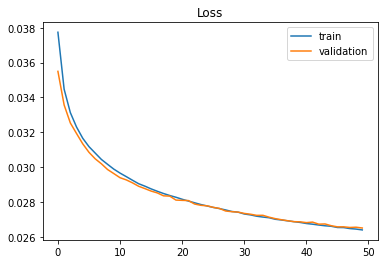

In [37]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='validation')
plt.legend()
plt.title("Loss")
plt.show()

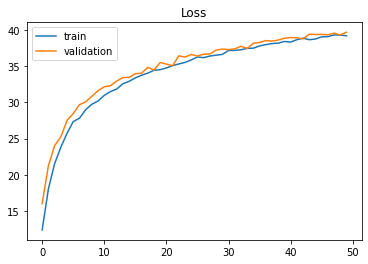

In [38]:
plt.plot(train_acc,label='train')
plt.plot(val_acc,label='validation')
plt.legend()
plt.title("Loss")
plt.show()